## **Введение**  

Данный проект посвящён исследованию пользовательских комментариев, оставленных под видео на YouTube.

**Цель работы** — изучить факторы, влияющие на популярность комментариев, и разработать модель, способную предсказывать количество лайков, которое может получить комментарий. 

**Задачи**
1. Сбор данных о комментариях, видео и каналах с использованием API YouTube.
2. Обработка данных, включая вычисление доплнительных параметров, таких как длина текста или эмоциональность.
3. Исследование зависимостей популярности комментариев от длины текста, времени публикации и их эмоциональной окраски.
4. Разработка модели машинного обучения для прогнозирования популярности комментариев.

## **Сбор данных**  

### **Формирование списка анализируемых каналов**  

На первом этапе проекта необходимо было составить перечень YouTube-каналов для анализа комментариев. Основу выборки составили русскоязычные научно-популярные каналы. Список каналов был взят с сайта [Pikabu](https://pikabu.ru/story/spisok_vsekh_nauchnopopulyarnyikh_i_obrazovatelnyikh_kanalov_na_russkom_yazyike_versiya_07082018_6081962) и преобразован в табличный формат для удобства дальнейшей работы.  

Работа включала следующие шаги:  
1. Загрузка HTML-страницы со списком каналов с помощью библиотеки `requests`.  
2. Извлечение названий каналов, их идентификаторов (`channel_id`) и ссылок с использованием регулярных выражений (`re`).  
3. Расширение выборки вручную за счёт добавления нескольких популярных каналов.  

На выходе получилась таблица с тремя колонками:  
- **Название канала** (Channel name);  
- **Идентификатор канала** (Channel ID);  
- **Ссылка на канал** (Channel URL).  

Итоговый набор данных был сохранён в файл `channels.csv` для последующего анализа.  

In [38]:
import requests
import re
import pandas as pd
from time import sleep

if input('Load from file "channels.csv"? Y/n: ').lower() in ['y', '']:
    CHANNELS = pd.read_csv("data/channels.csv", index_col=False)
else:
    url = 'https://pikabu.ru/story/spisok_vsekh_nauchnopopulyarnyikh_i_obrazovatelnyikh_kanalov_na_russkom_yazyike_versiya_07082018_6081962'
    
    response = requests.get(url)

    page_content = response.text.replace("/featured", '').replace("/videos", '').replace("/feed", '')

    # Extract channel names, IDs, and URLs using regular expressions
    channel_names = re.findall(r'(?<=\"nofollow noopener\"\>)[^\<]+(?=\<\/a\>)', page_content)[1:-2]
    channel_urls = re.findall(r'https:\/\/www\.youtube\.com[a-zA-Z0-9\-\/\_]+', page_content)
    channel_ids = [channel_id[channel_id.rfind('/') + 1:] for channel_id in channel_urls]

    extra_channels = {
        "Channel name": ["ALI", "foo52ru ТехноШаман", "KrashheR", "Simple Math", "АНТРОПОГЕНЕЗ.РУ",
                         "Thoisoi", "Доктор Грег", "Хауди Хо™ - Просто о мире IT!", "Вселенная Плюс", "Неземной подкаст Владимира Сурдина"],
        "Channel id": ["UCA5CVgzJoxt_v36DwfhB5dw", "UCP1JsJgeNs86oqLGnjfGo9Q", "UCqcRFvvwQSMWJZV-Y8ai_Ug", "UC59w9x18hNNELpDvmo1UhVQ", "UCmeHX75iiqezgdKgYfrFKSA",
                       "UCjAmQ-4NL3UZX0W_nmjn4_w", "UC6DxE5GWRxZKwNdcOzV5hWw", "UC7f5bVxWsm3jlZIPDzOMcAg", "UCMrD1wosgsUpu3AE7IlIjZQ", "UC4WAsHhtleuEGKX9x_Kbd9w"]
    }

    extra_channels["Channel URL"] = ["https://youtube.com/channel/"+id for id in extra_channels["Channel id"]]

    CHANNELS = pd.DataFrame({
        "Channel name": channel_names + extra_channels["Channel name"],
        "Channel id": channel_ids + extra_channels["Channel id"],
        "Channel URL": channel_urls + extra_channels["Channel URL"]
    })

    CHANNELS = CHANNELS[CHANNELS["Channel URL"].str.contains("/channel/")]

    CHANNELS.to_csv("data/channels.csv", index=False)

CHANNELS


,Channel name,Channel id,Channel URL
0,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,https://www.youtube.com/channel/UCyjf5CxCNEc9A...
1,Prolegarium,UCnGeP_CYiOkgym9SconA2hg,https://www.youtube.com/channel/UCnGeP_CYiOkgy...
2,Skinner Show,UC2kh9KwsMmgj1LCAvwGU4HQ,https://www.youtube.com/channel/UC2kh9KwsMmgj1...
3,Utopia Show,UC8M5YVWQan_3Elm-URehz9w,https://www.youtube.com/channel/UC8M5YVWQan_3E...
4,Чуть-Чуть о Науке,UCKHEsjDfUOJpAev9cpjnrGg,https://www.youtube.com/channel/UCKHEsjDfUOJpA...
...,...,...,...
187,Thoisoi,UCjAmQ-4NL3UZX0W_nmjn4_w,https://youtube.com/channel/UCjAmQ-4NL3UZX0W_n...
188,Доктор Грег,UC6DxE5GWRxZKwNdcOzV5hWw,https://youtube.com/channel/UC6DxE5GWRxZKwNdcO...
189,Хауди Хо™ - Просто о мире IT!,UC7f5bVxWsm3jlZIPDzOMcAg,https://youtube.com/channel/UC7f5bVxWsm3jlZIPD...
190,Вселенная Плюс,UCMrD1wosgsUpu3AE7IlIjZQ,https://youtube.com/channel/UCMrD1wosgsUpu3AE7...


### **Сбор комментариев с каналов**  

После составления списка каналов начался этап сбора комментариев. Для этой задачи использовался YouTube API V3, который предоставляет доступ к метаданным и комментариям. Однако процесс был ограничен рядом факторов:  
- Суточный лимит API составляет 10 000 запросов.  
- Некоторые каналы оказались недоступны для сбора данных из-за отключённой функции комментирования или блокировки, что потребовало обработки ошибок.  

Процесс сбора данных был организован следующим образом:  
1. **Итерация по каналам.** Для каждого канала с использованием его идентификатора извлекались все связанные видео.  
2. **Извлечение комментариев.** Метод `commentThreads` API использовался для получения комментариев, включая текст, количество лайков, дату публикации и ответы.  
3. **Сохранение данных.** Собранные комментарии сохранялись в DataFrame. Чтобы избежать переполнения памяти, данные записывались в CSV-файл (`comments.csv`) каждые 100 запросов.  

В результате было собрано более 10 миллионов комментариев, что сформировало основу для статистического анализа и помогло минимизировать влияние случайных шумов.  


In [52]:
import os
import pandas as pd
from googleapiclient.discovery import build
from tqdm import tqdm
import configparser
import random
import ast

config = configparser.ConfigParser()
config.read("config.ini")

DEVELOPER_KEY = config["YouTube API V3"]['key']
QUOTA = 0
BATCH_SIZE = 100

service = build('youtube', 'v3', developerKey=DEVELOPER_KEY)

# Read saved state
with open('nextPageToken.txt', 'r') as file:
    channel_index = int(file.readline())
    used_channels = set(ast.literal_eval(file.readline()))
    next_page_token = file.readline()

def parse_comments(response):
    """Extract comments and replies from the API response."""
    comments = []
    for thread in response.get("items", []):
        comments.append(thread['snippet']['topLevelComment']['snippet'])  # Top-level comment
        comments.extend(reply['snippet'] for reply in thread.get('replies', {}).get('comments', []))  # Replies
    return comments

def update_comments_dataframe(comments_df, comments):
    """Append new comments to the DataFrame."""
    new_comments_df = pd.json_normalize(comments)
    new_comments_df = new_comments_df[['channelId', 'videoId', 'textOriginal', 'likeCount', 'publishedAt']]
    new_comments_df.columns = ["Channel ID", "Video ID", "Text", "Likes", "Publication Date"]
    return pd.concat([comments_df, new_comments_df], ignore_index=True)

# Initialize variables
COMMENTS = pd.DataFrame()
batch_counter = 0

# Fetch comments
for _ in tqdm(range(QUOTA), desc="Loading comments"):
    channel_id = CHANNELS.iloc[channel_index]["Channel id"]
    try:
        response = service.commentThreads().list(
            part="id,snippet,replies",
            allThreadsRelatedToChannelId=channel_id,
            pageToken=next_page_token or None,
            maxResults=100
        ).execute()

        # Parse and update comments
        comments = parse_comments(response)
        if comments:
            COMMENTS = update_comments_dataframe(COMMENTS, comments)

        # Handle pagination or move to the next channel
        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            used_channels.add(channel_index)
            available_channels = set(range(len(CHANNELS))) - used_channels
            channel_index = random.choice(list(available_channels))

        # Save in batches
        batch_counter += 1
        if batch_counter == BATCH_SIZE:
            COMMENTS.to_csv("data/comments.csv", index=False, mode='a', header=not os.path.isfile("data/comments.csv"))
            COMMENTS = pd.DataFrame()
            batch_counter = 0

    except Exception as e:
        print(f"Error: {e}")
        if "has disabled comments" in str(e):
            used_channels.add(channel_index)
            available_channels = set(range(len(CHANNELS))) - used_channels
            channel_index = random.choice(list(available_channels))
        else:
            break

# Save the final state
with open('nextPageToken.txt', 'w') as file:
    file.write(f"{channel_index}\n{str(used_channels)}\n{next_page_token or ''}")

# Save remaining comments
if not COMMENTS.empty:
    COMMENTS.to_csv("data/comments.csv", index=False, mode='a', header=not os.path.isfile("data/comments.csv"))


Loading comments: 0it [00:00, ?it/s]


### **Сбор метаданных о видео**  

Для расширения возможностей анализа были собраны метаданные о видео, включая:  
- **Название видео** (Video title);  
- **Дата публикации** (Video publication date);  
- **Количество просмотров** (Video views).  

Эти данные были сохранены в файл `videos.csv`.  

На этом этапе сформирована "база данных", которая объединяет информацию о каналах, видео и комментариях. Это позволяет анализировать взаимосвязи между популярностью видео и активностью пользователей в комментариях.  


In [53]:
CHANNELS = pd.read_csv("data/channels.csv")

def get_videos_by_channel(channel_id):
    """Fetch all videos for a given channel ID and return them as a DataFrame."""
    video_ids, video_titles, video_publish_dates = [], [], []

    channel_response = service.channels().list(
        part='contentDetails',
        id=channel_id
    ).execute()

    playlist_id = channel_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    # Fetch all videos from the playlist
    next_page_token = None
    while True:
        playlist_response = service.playlistItems().list(
            part='snippet',
            playlistId=playlist_id,
            maxResults=100,
            pageToken=next_page_token
        ).execute()

        # Collect video details
        for item in playlist_response['items']:
            video_ids.append(item['snippet']['resourceId']['videoId'])
            video_titles.append(item['snippet']['title'])
            video_publish_dates.append(item['snippet']['publishedAt'])

        # Check for the next page
        next_page_token = playlist_response.get('nextPageToken')
        if not next_page_token:
            break

    # Fetch view counts in batches of 50 videos
    video_views = []
    for i in range(0, len(video_ids), 50):
        video_response = service.videos().list(
            part='statistics',
            id=','.join(video_ids[i:i + 50])
        ).execute()

        video_views.extend(
            item['statistics'].get('viewCount', 0) for item in video_response['items']
        )

    return pd.DataFrame({
        'Video id': video_ids,
        'Video title': video_titles,
        'Video publication date': video_publish_dates,
        'Video views': video_views
    })

if input('Load from file "videos.csv"? Y/n: ').strip().lower() in {'y', ''}:
    VIDEOS = pd.read_csv("data/videos.csv", index_col=False)
else:
    VIDEOS = pd.DataFrame(columns=['Video id', 'Video title', 'Video publication date', 'Video views'])

    for channel_id in CHANNELS['Channel id']:
        try:
            channel_name = CHANNELS.loc[CHANNELS["Channel id"] == channel_id, "Channel name"].iloc[0]
            print(f"Processing channel: {channel_name} ({channel_id})")

            channel_videos = get_videos_by_channel(channel_id)
            channel_videos.to_csv(
                "data/videos.csv", index=False, mode='a', header=not os.path.isfile("data/videos.csv")
            )
        except Exception as e:
            print(f"Error processing channel {channel_id}: {e}")

    VIDEOS = pd.read_csv("data/videos.csv", index_col=False)

VIDEOS


,Video id,Video title,Video publish date,Video views
0,KTcjP48sG3Y,САМЫЙ СТРАШНЫЙ ПЕРИОД США | ВЕЛИКАЯ ДЕПРЕССИЯ,2024-10-14T20:20:04Z,1627068
1,LNnxmBHOlOQ,История Конфуцианства - Конфуций [GEO],2024-09-06T18:27:40Z,954871
2,E2--ncO_fhY,Фукусима: САМАЯ СТРАШНАЯ ЯДЕРНАЯ КАТАСТРОФА 21...,2024-07-23T17:49:01Z,3115484
3,eLB9JoYuj7s,"ПРОРОЧЕСТВА, которые потрясли МИР! | Нострадам...",2024-05-31T17:20:00Z,4221508
4,cd9wTqHuUBw,Зодиак: Американский Задрот Убийца [Расследова...,2024-04-29T15:37:37Z,2074254
...,...,...,...,...
51956,uCRMVCyLUIg,Владимир Сурдин. ЗАГАДОЧНЫЕ находки на Венере....,2021-03-05T11:11:32Z,137136
51957,DTtS_dYSOJU,"История марсоходов: от «Марс-3» до ""Perseveran...",2021-02-18T21:28:27Z,49078
51958,hT08g1zreWE,На Марсе классно? Астроном Сурдин vs Noize MC....,2021-02-11T11:12:42Z,42493
51959,_ofEQNzC5A8,"Сурдин: Falcon 9, Starlink и другие проекты Ма...",2021-02-08T09:51:39Z,107605


### **Подготовка данных для анализа**  

Заключительным этапом подготовки данных стало объединение всех собранных сведений в единый DataFrame. Он включал:  
- **Текст комментариев** и связанные метаданные: длина текста, количество лайков, временные характеристики;  
- **Эмоциональную окраску комментариев** (позитивная, нейтральная, негативная), определённую с помощью модели `Dostoevsky`;  
- **Метаданные о видео**, такие как дата публикации и количество просмотров.  

Объединённый датасет был сохранён в файл `alldata.csv`.  

In [54]:
import datetime
import numpy as np
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

# Command to download the FastText social network model
# python -m dostoevsky download fasttext-social-network-model

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

def get_sentiment(text):
    """Analyze the sentiment of the provided text."""
    results = model.predict([text])[0]
    return {key: results[key] for key in ["negative", "neutral", "positive"]}

def parse_iso_date(date_str):
    """Convert an ISO 8601 date string to a datetime object."""
    try:
        return datetime.datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ')
    except ValueError:
        return np.NaN


In [2]:
from math import log, atan, pi
import os
import pandas as pd

if input('Load from file "alldata.csv"? Y/n: ').lower() in ['y', '']:
    ALL_DATA = pd.read_csv("data/alldata.csv", index_col=0)
else:
    COMMENTS = pd.read_csv("data/comments.csv")
    VIDEOS = pd.read_csv("data/videos.csv")

    # Merge data from comments and videos
    ALL_DATA = COMMENTS.join(CHANNELS[["Channel name", "Channel id"]].set_index("Channel id"), on="Channel id")
    ALL_DATA = ALL_DATA.join(VIDEOS.set_index("Video id"), on="Video id")

    # Add text length column
    print("Text len:", end=' ')
    ALL_DATA['Text len'] = ALL_DATA['Text'].astype(str).str.len()
    print("Done")

    # Add sentiment weights
    print("Negative weight, Neutral weight, Positive weight:", end=' ')
    ALL_DATA[["Negative weight", "Neutral weight", "Positive weight"]] = ALL_DATA["Text"].astype(str).apply(get_sentiment).apply(pd.Series)
    print("Done")

    # Normalize sentiment weights
    print("Weights normalization:", end=' ')
    sums = ALL_DATA[["Positive weight", "Negative weight", "Neutral weight"]].sum(axis=1)
    ALL_DATA[["Positive weight", "Negative weight", "Neutral weight"]] = ALL_DATA[["Positive weight", "Negative weight", "Neutral weight"]].div(sums, axis=0)
    print("Done")

    # Calculate sentiment
    print("Sentiment:", end=' ')
    ALL_DATA["Sentiment 1"] = (ALL_DATA["Positive weight"] / ALL_DATA["Negative weight"]).apply(log).apply(atan) * (1 - ALL_DATA["Neutral weight"]) * 200 / pi
    ALL_DATA["Sentiment 2"] = 100 * (ALL_DATA["Positive weight"]**2 - ALL_DATA["Negative weight"]**2)
    print("Done")

    # Calculate time delta
    print("Time delta:", end=' ')
    ALL_DATA["Time delta"] = (ALL_DATA["Publication date"].apply(parse_iso_date) - ALL_DATA["Video publication date"].apply(parse_iso_date)).total_seconds() // 60
    ALL_DATA = ALL_DATA[ALL_DATA["Time delta"] >= 0]
    print("Done")

    ALL_DATA = ALL_DATA[["Channel name", "Channel id",
                         "Video title", "Video id", "Video views",
                         "Text", "Text len",
                         "Negative weight", "Neutral weight", "Positive weight",
                         "Sentiment 1", "Sentiment 2", "Likes",
                         "Publication date", "Video publication date", "Time delta"]]

    print("Writing to file:", end=' ')
    ALL_DATA.to_csv("data/alldata.csv", index=False)
    print("Done")

ALL_DATA


,Channel name,Channel id,Video title,Video id,Video views,Text,Text len,Negative weight,Neutral weight,Positive weight,Sentiment 1,Sentiment 2,Likes,Publication date,Video publication date,Time delta
0,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,Космическая Гонка: Почему больше НЕ ЛЕТАЮТ на ...,_P0ZK8xW8-4,8989345.0,"Куда только медкомиссия смотрела, когда набира...",346,0.444075,0.528057,0.027869,-36.780040,-19.642554,0,2024-11-01T08:38:16Z,2023-12-19T21:54:09Z,457124.0
1,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,САМЫЙ СТРАШНЫЙ ПЕРИОД США | ВЕЛИКАЯ ДЕПРЕССИЯ,KTcjP48sG3Y,1627068.0,"Какой же кайф, у меня будет хороший вечер) огр...",91,0.103586,0.095041,0.801373,64.304022,63.146787,0,2024-11-01T08:06:52Z,2024-10-14T20:20:04Z,25186.0
2,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,Как Уничтожили Сомалийских Пиратов? [GEO],xgQBGAiv5Ok,3514255.0,М! Позновательно! Теперь всё понятно что да ка...,163,0.172578,0.351540,0.475882,32.716451,19.668028,0,2024-11-01T08:06:34Z,2024-03-14T20:06:44Z,333359.0
3,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,ХУДШИЙ РЕЖИССЕР В ИСТОРИИ [История в Личностях],7v5WsSoU1gw,1799338.0,ДИЗ за тупую рекламу,20,0.003689,0.996300,0.000011,-0.330165,-0.001361,0,2024-11-01T07:20:58Z,2021-10-11T13:41:27Z,1608099.0
4,GEO,UCyjf5CxCNEc9ALYlalBiKDQ,САМЫЙ СТРАШНЫЙ ПЕРИОД США | ВЕЛИКАЯ ДЕПРЕССИЯ,KTcjP48sG3Y,1627068.0,Гео красавчик,13,0.000010,0.000010,0.999980,94.483294,99.996000,0,2024-11-01T07:09:25Z,2024-10-14T20:20:04Z,25129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10076128,Хауди Хо™ - Просто о мире IT!,UC7f5bVxWsm3jlZIPDzOMcAg,НОВЫЙ 100% РАБОЧИЙ ФИКС ДИСКОРД + ЮТУБ | ВОЙС ...,xjtTm3F2pWk,311356.0,"💗 С вас лайк, я старался :3\nСборку качаем тол...",138,0.049752,0.913348,0.036900,-1.601893,-0.111363,114,2024-10-13T15:38:46Z,2024-10-13T15:36:49Z,1.0
10076129,Хауди Хо™ - Просто о мире IT!,UC7f5bVxWsm3jlZIPDzOMcAg,Как сделать ЛЮБОЙ сайт? За 10 минут!,r8Y0TFVVfZY,94190.0,"Расходимся тут нет не фронта не бэка, только 1...",80,0.289154,0.689310,0.021536,-23.799588,-8.314639,425,2024-06-30T15:37:01Z,2024-06-30T14:26:04Z,70.0
10076130,Хауди Хо™ - Просто о мире IT!,UC7f5bVxWsm3jlZIPDzOMcAg,Как сделать ЛЮБОЙ сайт? За 10 минут!,r8Y0TFVVfZY,94190.0,Как всегда короче,17,0.092687,0.894791,0.012522,-7.417823,-0.843411,16,2024-06-30T19:08:07Z,2024-06-30T14:26:04Z,282.0
10076131,Хауди Хо™ - Просто о мире IT!,UC7f5bVxWsm3jlZIPDzOMcAg,Я сделал ИИ для CS2 и она его уничтожила 3,8QWEk11UluM,384598.0,Хауди пишет чит для кс 2 и оправдывается нейро...,70,0.052577,0.941402,0.006021,-4.246995,-0.272813,1683,2024-05-24T18:09:50Z,2024-05-24T16:30:17Z,99.0


## **Визуализация данных и анализ комментариев**

### **Анализ длины комментариев**

На основе жизненного опыта можно предположить, что на таких платформах, как YouTube, пользователи склонны оставлять короткие комментарии. Длинные комментарии встречаются реже, что связано с тем, что их написание требует больше времени. Также логично предположить, что длина комментария может оказывать влияние на его популярность. Для проверки этих гипотез были построены графики, отображающие связь между длиной комментариев и другими параметрами.

#### **Распределение комментариев по длине**

Первым шагом было построение графика распределения количества комментариев в зависимости от их длины с помощью библиотеки `matplotlib` и написанной функции `plot_count`.

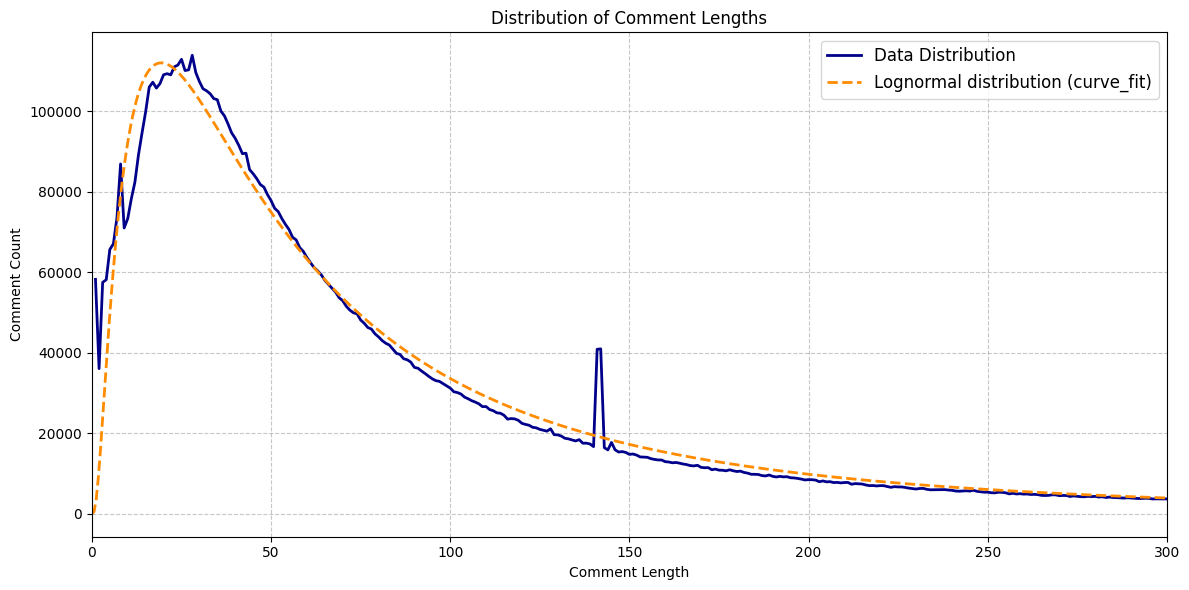

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import curve_fit

def plot_count(ax, column, xstep=None, normalize=False, **kwargs):
    """Plot the distribution of data values."""
    plot_data = ALL_DATA[column].dropna()
    if xstep:
        plot_data = plot_data.apply(lambda x: (x // xstep) * xstep)  # Round values to the nearest step
    plot_data = plot_data.value_counts(normalize=normalize).sort_index()
    ax.plot(plot_data.index, plot_data.values, **kwargs)
    return plot_data

def lognorm_pdf(x, sigma, scale):
    """Log-normal probability density function."""
    return lognorm.pdf(x, sigma, scale=scale)

def fit_lognorm(data):
    """Fit log-normal distribution to data."""
    norm_data = data/data.sum()
    popt, _ = curve_fit(lognorm_pdf, norm_data.index, norm_data.values, p0=[1, 100])
    return popt

fig, ax = plt.subplots(figsize=(12, 6))
xlim = (0, 300)

# Plot the data distribution
plot_data = plot_count(ax, "Text len", color="darkblue", linewidth=2, label="Data Distribution")

# Fit and plot the log-normal distribution
sigma, scale = fit_lognorm(plot_data)
x = np.linspace(*xlim, 500)
ax.plot(x, lognorm.pdf(x, sigma, scale=scale)*ALL_DATA.shape[0], color="darkorange", linewidth=2, linestyle="--", label="Lognormal distribution (curve_fit)")

ax.set(xlim=xlim, xlabel="Comment Length", ylabel="Comment Count", title="Distribution of Comment Lengths")
ax.grid(True, linestyle="--", alpha=0.7)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


**Анализ графика**

График демонстрирует, что распределение комментариев по длине существенно отличается от равномерного. Наибольшее количество комментариев приходится на длину 30-40 символов. Это, вероятно, оптимальная длина, которая позволяет выразить мысль, не требуя значительных затрат времени на написание.

Из-за большого объёма данных график получился достаточно гладким, что сильнее подчёркивает некоторые выбросы. Самый заметный из них расположен в диапазоне 141-142 символов. Для дальнейшего исследования причин этой аномалии были выведены комментарии этой длины, отсортированные по количеству повторений.


In [7]:
test = ALL_DATA[ALL_DATA["Text len"].isin([141,142])]
test = test.groupby("Text")["Text"].count().sort_values(ascending=False)
test.head(10)

Text
Здравствуйте. Пoжaлуйстa, посмотрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Cтоит дальше делать, или я бездарность!    5780
Здравствуйте. Пожaлуйстa, посмотрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Cтоит дальше делать, или я бездарность!    5712
Здравствуйте. Пoжaлуйстa, пoсмотрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Cтоит дальше делать, или я бездарность!    5680
Здравствуйте. Пoжaлуйстa, пoсмoтрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Cтоит дальше делать, или я бездарность!    5591
Здравcтвуйте. Пожaлуйcтa, посмотрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Cтоит новые делать, или я бездарность!     4460
Здравcтвуйте. Пожaлуйстa, посмотрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Cтоит новые делать, или я бездарность!     4441
Здравствуйте. Пожaлуйстa, посмотрите мои ролики. Не прошу подписаться! Просто нужно мнени

Просмотрев комментарии этой длины, стало ясно, что среди них встречаются дублирующиеся тексты, которые и вызывают такой необычный пик на графике. Например, следующий комментарий был обнаружен с различными вариациями более 40 000 раз, что сильно напоминает рекламную активность с использованием ботов:

> *Здравствуйте. Пожалуйста, посмотрите мои ролики. Не прошу подписаться! Просто нужно мнение со стороны. Стоит ли продолжать делать видео, или я бездарность?*

#### **Взаимосвязь между длиной комментария и количеством лайков**

Для изучения зависимости между количеством лайков и длиной комментария была написана функция `plot_likes`. С её помощью были построены графики, показывающие среднее количество лайков в зависимости от длины комментария.

Для улучшения читаемости графиков и их сглаживания применялись два подхода:
- **Удаление выбросов** с помощью функции `drop_outliers`.
- **Сглаживание с использованием скользящего среднего**, настроенного через параметр `MA_window`.


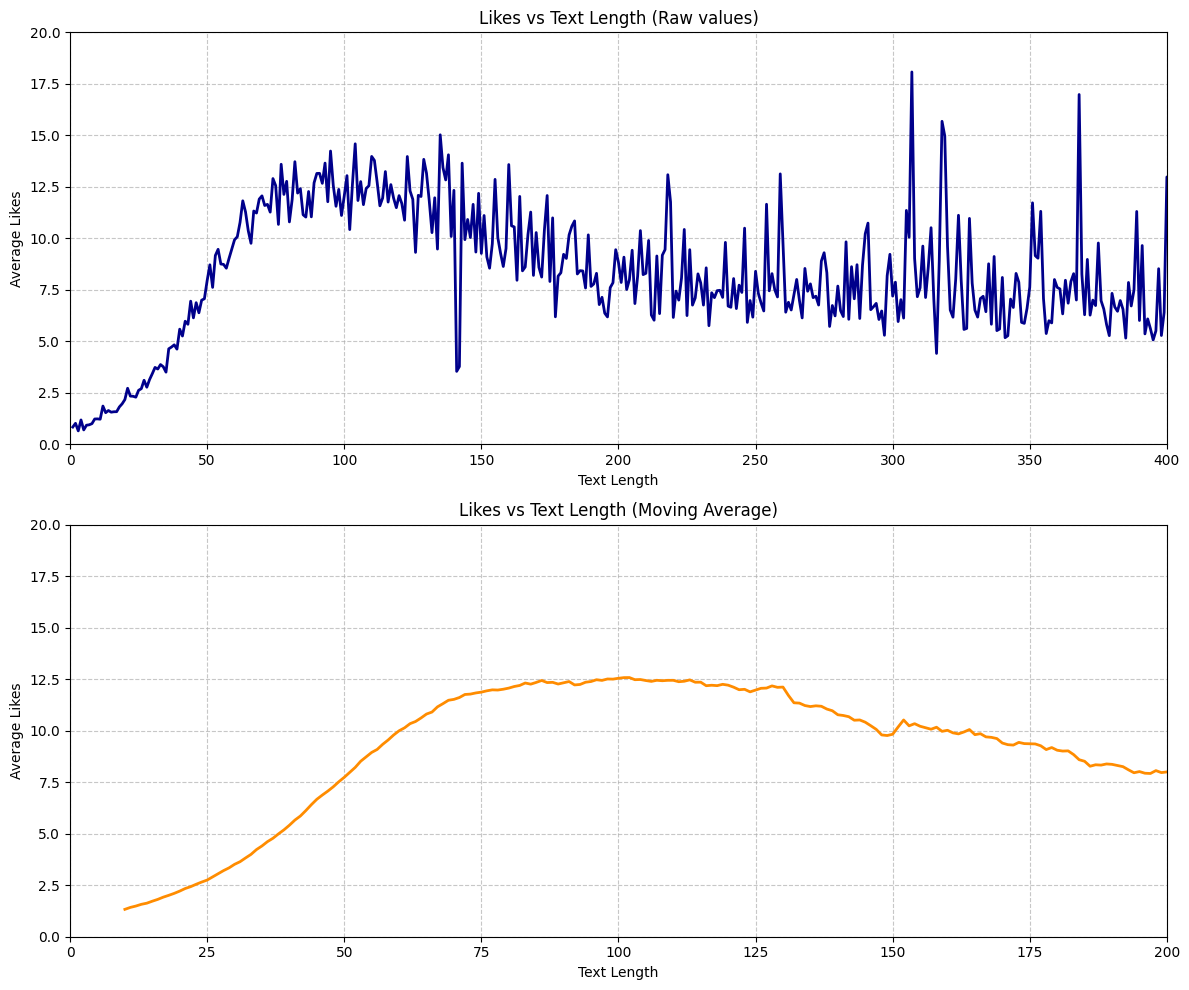

In [78]:
def drop_outliers(data, column, quantile=0.75):
    """Remove outliers by filtering values above the specified quantile."""
    max_threshold = data[column].quantile(quantile)
    return data[data[column] <= max_threshold]

def plot_likes(ax, column, xstep=None, quantile=1, MA_window=None, **kwargs):
    """Plot the average likes per text length with optional moving average and quantile filtering."""
    plot_data = ALL_DATA[[column, "Likes"]].dropna()
    
    if xstep:
        plot_data[column] = plot_data[column].apply(lambda x: (x // xstep) * xstep)  # Round values to nearest step
    
    # Remove outliers and calculate mean likes per text length
    plot_data = drop_outliers(plot_data, "Likes", quantile)
    plot_data = plot_data.groupby(column).mean()
    
    # Apply moving average if specified
    if MA_window:
        plot_data = plot_data.rolling(MA_window).mean()
        plot_data.index = plot_data.index - MA_window / 2  # Adjust index to center moving window
    
    ax.plot(plot_data, **kwargs)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Likes vs Text Length (Raw values)
ax[0].set(xlim=(0, 400), ylim=(0, 20), xlabel="Text Length", ylabel="Average Likes", title="Likes vs Text Length (Raw values)")
ax[0].grid(True, linestyle="--", alpha=0.7)

# Plot 2: Likes vs Text Length (With Moving Average)
ax[1].set(xlim=(0, 200), ylim=(0, 20), xlabel="Text Length", ylabel="Average Likes", title="Likes vs Text Length (Moving Average)")
ax[1].grid(True, linestyle="--", alpha=0.7)

# Plot the data
plot_likes(ax[0], "Text len", color="darkblue", linewidth=2)
plot_likes(ax[1], "Text len", MA_window=20, color="darkorange", linewidth=2)

plt.tight_layout()
plt.show()


**Анализ графиков**

График показывает, что наибольшее количество лайков в среднем получают комментарии длиной 75-125 символов. Это объясняется тем, что короткие комментарии не содержат достаточного количества информации, чтобы заинтересовать пользователей, в то время как слишком длинные комментарии могут "отпугнуть" тех, кто не готов тратить много времени на их чтение.

На графике также можно заметить резкий спад. Для того чтобы выяснить его причину, было проведено сравнение графиков, отображающих количество комментариев и среднее количество лайков.

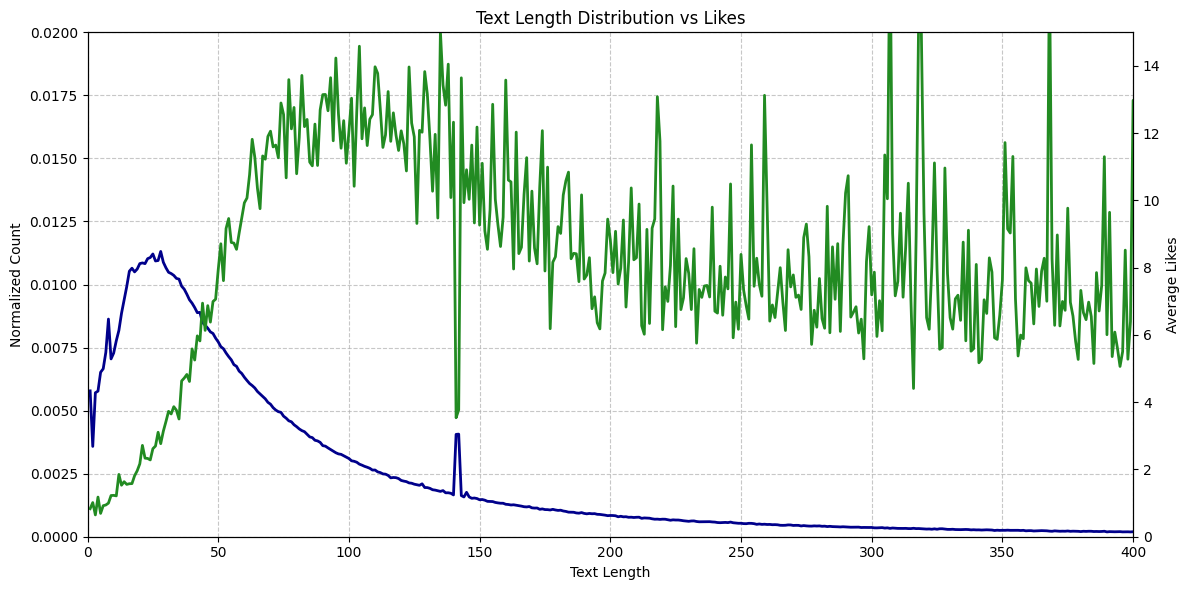

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()  # Create a second y-axis

# Set axis limits and labels
ax.set(xlim=(0, 400), ylim=(0, 0.02), xlabel="Text Length", ylabel="Normalized Count", title="Text Length Distribution vs Likes")
ax2.set(xlim=(0, 400), ylim=(0, 15), ylabel="Average Likes")

ax.grid(True, linestyle="--", alpha=0.7)
ax2.grid(False)

# Plot data
plot_count(ax, "Text len", normalize=True, color='darkblue', linewidth=2)
plot_likes(ax2, "Text len", color='forestgreen', linewidth=2)

plt.tight_layout()
plt.show()


**Анализ графика**

Изучив этот график, можно сделать вывод, что причиной резкого падения лайков являются те же спам-комментарии, которые вызывают выбросы на графике количества комментариев. Действительно, никто не будет лайкать комментарий, явно написанный ботом. В совокупности с огромным количеством таких комментариев это сильно снижает среднее количество лайков.

Кроме того, на графике видно, что пики количества комментариев и лайков не совпадают. Это означает, что наиболее популярные комментарии длиной 30-40 символов, вероятно, не содержат достаточно информации, чтобы быть интересными другим пользователям. Для этого требуется не менее 100 символов.

### **Анализ временных характеристик**

Интуитивно можно предположить, что время публикации комментария также влияет на его популярность. По крайней мере, комментарий, опубликованный раньше, вероятно, будет просмотрен большим числом пользователей. Для проверки этой гипотезы были построены несколько графиков, связанных с временными характеристиками.

#### **Распределение комментариев по времени**

В первую очередь было исследовано количественное распределение комментариев в зависимости от времени, прошедшего с момента публикации видео.

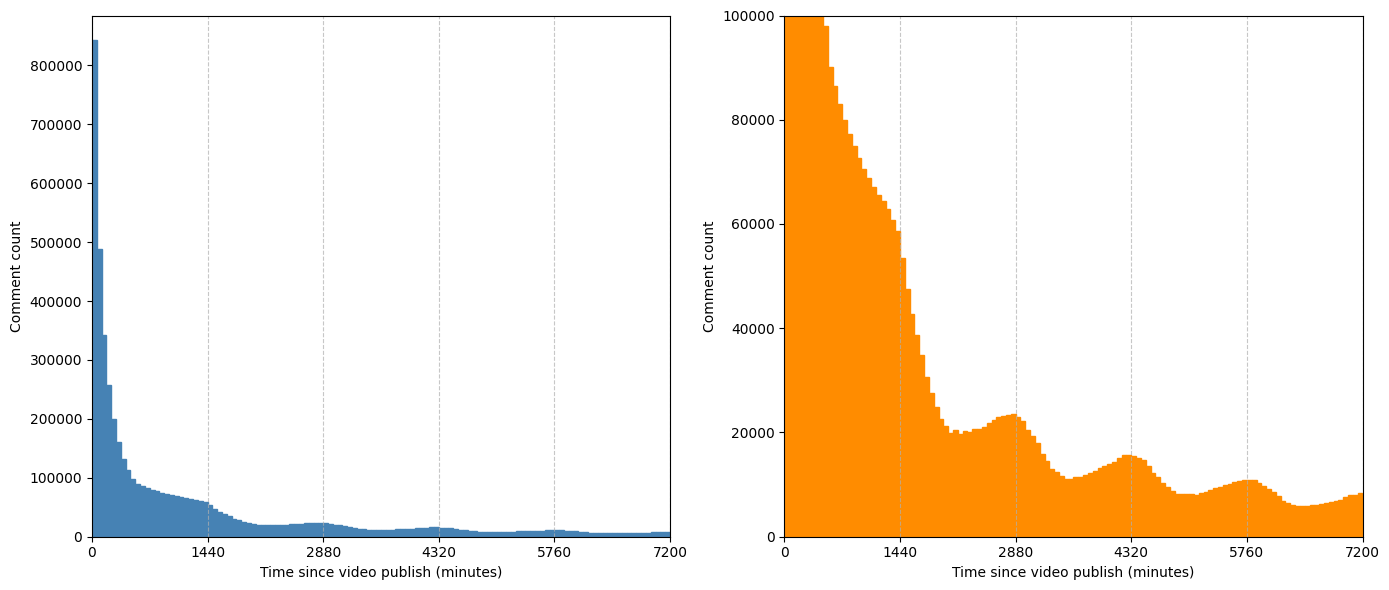

In [81]:
n_days = 5  # Number of days to plot

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for axis in ax:
    axis.set(xlim=(0, 1440 * n_days), xlabel="Time since video publish (minutes)", ylabel="Comment count")
    axis.set_xticks(range(0, 1440 * n_days + 1, 1440))
    axis.grid(axis='x', linestyle='--', alpha=0.7)

ax[1].set(ylim=(0, 100000))

# Plot histograms
ax[0].hist(ALL_DATA["Time delta"], bins=24 * n_days, range=(0, 1440 * n_days), color="steelblue", edgecolor="steelblue")
ax[1].hist(ALL_DATA["Time delta"], bins=24 * n_days, range=(0, 1440 * n_days), color="darkorange", edgecolor="darkorange")

plt.tight_layout()
plt.show()


**Анализ графиков**

На графиках видно, что основная масса комментариев оставляется пользователями в первые несколько часов после публикации видео. Это обусловлено как алгоритмами платформы, которые рекомендуют новые видео для просмотра, так и уведомлениями, поступающими подписчикам о выходе новых роликов.

Интересно, что количество комментариев не просто постепенно уменьшается с течением времени, а имеет явно выраженные волнообразные колебания. Период этих колебаний точно равен 1440 минутам, то есть суткам. Это указывает на то, что колебания отражают ежедневные изменения в трафике платформы.

Стоит отметить, что появление этих волн на графиках стало возможным благодаря выбору русскоязычных каналов. Основная аудитория этих каналов состоит из жителей СНГ, что приводит к тому, что большинство авторов выкладывают свои видео примерно в одно и то же время. Если бы для анализа были выбраны иностранные каналы, разница в часовых поясах сгладила бы эти колебания.

Ещё одно интересное наблюдение — пики активности приходятся на 1440, 2880, 4320 и т. д. минуты. Эта закономерность подтверждает, что авторы видео действительно хорошо знают, в какое время онлайн платформы максимален, и выкладывают ролики именно в это время.

#### **Зависимость количества лайков от времени**

Далее была исследована зависимость количества лайков, получаемых комментариями, от временных характеристик. Для более глубокого анализа было учтено также время публикации видео. Рассмотрены первые сутки после публикации, и для наглядности построена тепловая карта.

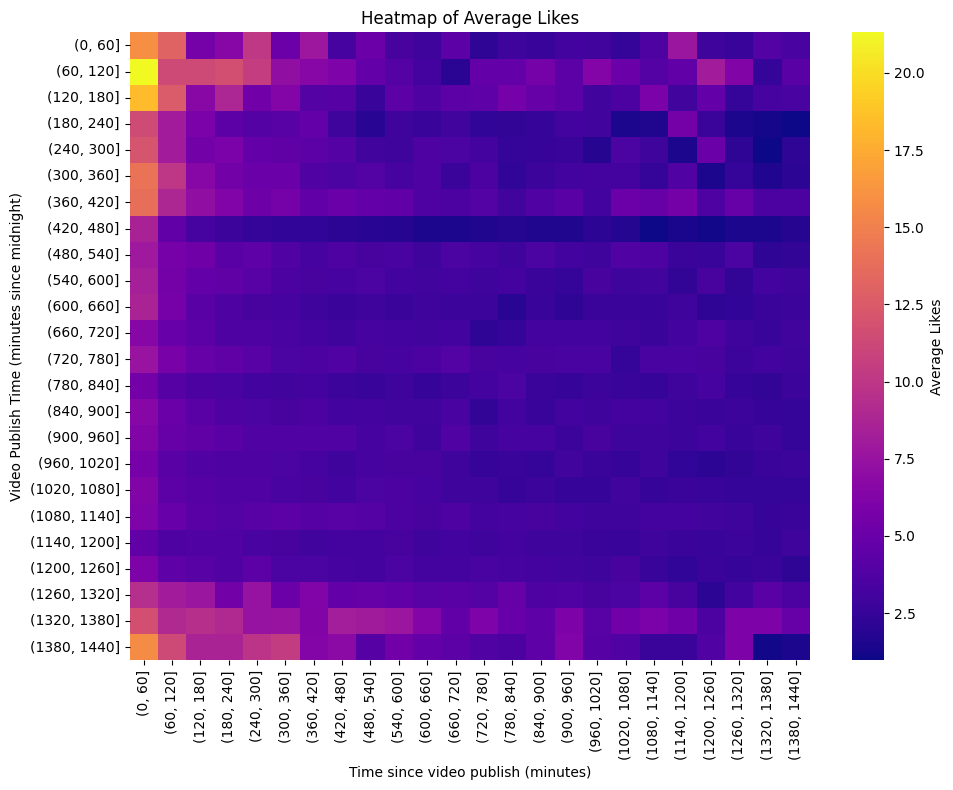

In [82]:
import seaborn as sns

plot_data = ALL_DATA[["Video publication date", "Time delta", "Likes"]]

plot_data = plot_data[plot_data["Time delta"] <= 1440]

plot_data["Video time"] = plot_data["Video publication date"].apply(parse_iso_date).apply(lambda dt: dt.time().hour*60 + dt.time().minute)

plot_data = drop_outliers(plot_data, "Likes", 0.995)

time_step = 60

plot_data["x"] = pd.cut(plot_data["Time delta"], pd.interval_range(start=0, end=1440, periods=1440//time_step))
plot_data["y"] = pd.cut(plot_data["Video time"], pd.interval_range(start=0, end=1440, periods=1440//time_step))

plot_data = plot_data[["x", "y", "Likes"]].groupby(by=["x", "y"], as_index=False).mean()
plot_data = plot_data.dropna()

heatmap_data = plot_data.pivot(index="y", columns="x", values="Likes")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="plasma", cbar_kws={"label": "Average Likes"})

plt.xlabel("Time since video publish (minutes)")
plt.ylabel("Video Publish Time (minutes since midnight)")
plt.title("Heatmap of Average Likes")

plt.tight_layout()
plt.show()

**Анализ графика**

График подтверждает наличие зависимости между временными характеристиками и средним количеством лайков. Комментарии, оставленные в первые часы после публикации видео, получают больше лайков, что видно по градиенту, направленному слева направо. Также время публикации видео оказывает влияние: наибольшее количество лайков получают комментарии под видео, опубликованными в начале или в конце суток по UTC.

#### **Зависимость количества лайков от года**

Теперь рассмотрим более широкий временной диапазон: как изменялось среднее количество лайков, получаемых комментариями, с каждым годом.

In [16]:
plot_data = ALL_DATA[["Video publication date", "Likes"]]
plot_data["Video publication date"] = plot_data["Video publication date"].apply(parse_iso_date)

plot_data['Month'] = plot_data['Video publication date'].dt.to_period('M').dt.to_timestamp()
plot_data['Year'] = plot_data['Video publication date'].dt.to_period('Y').dt.to_timestamp()

C:\Users\ivan\AppData\Local\Temp\ipykernel_4220\3351748260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["Video publication date"] = plot_data["Video publication date"].apply(parse_iso_date)
C:\Users\ivan\AppData\Local\Temp\ipykernel_4220\3351748260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Month'] = plot_data['Video publication date'].dt.to_period('M').dt.to_timestamp()
C:\Users\ivan\AppData\Local\Temp\ipykernel_4220\3351748260.py:5: SettingWithCopyWarning: 
A value is 

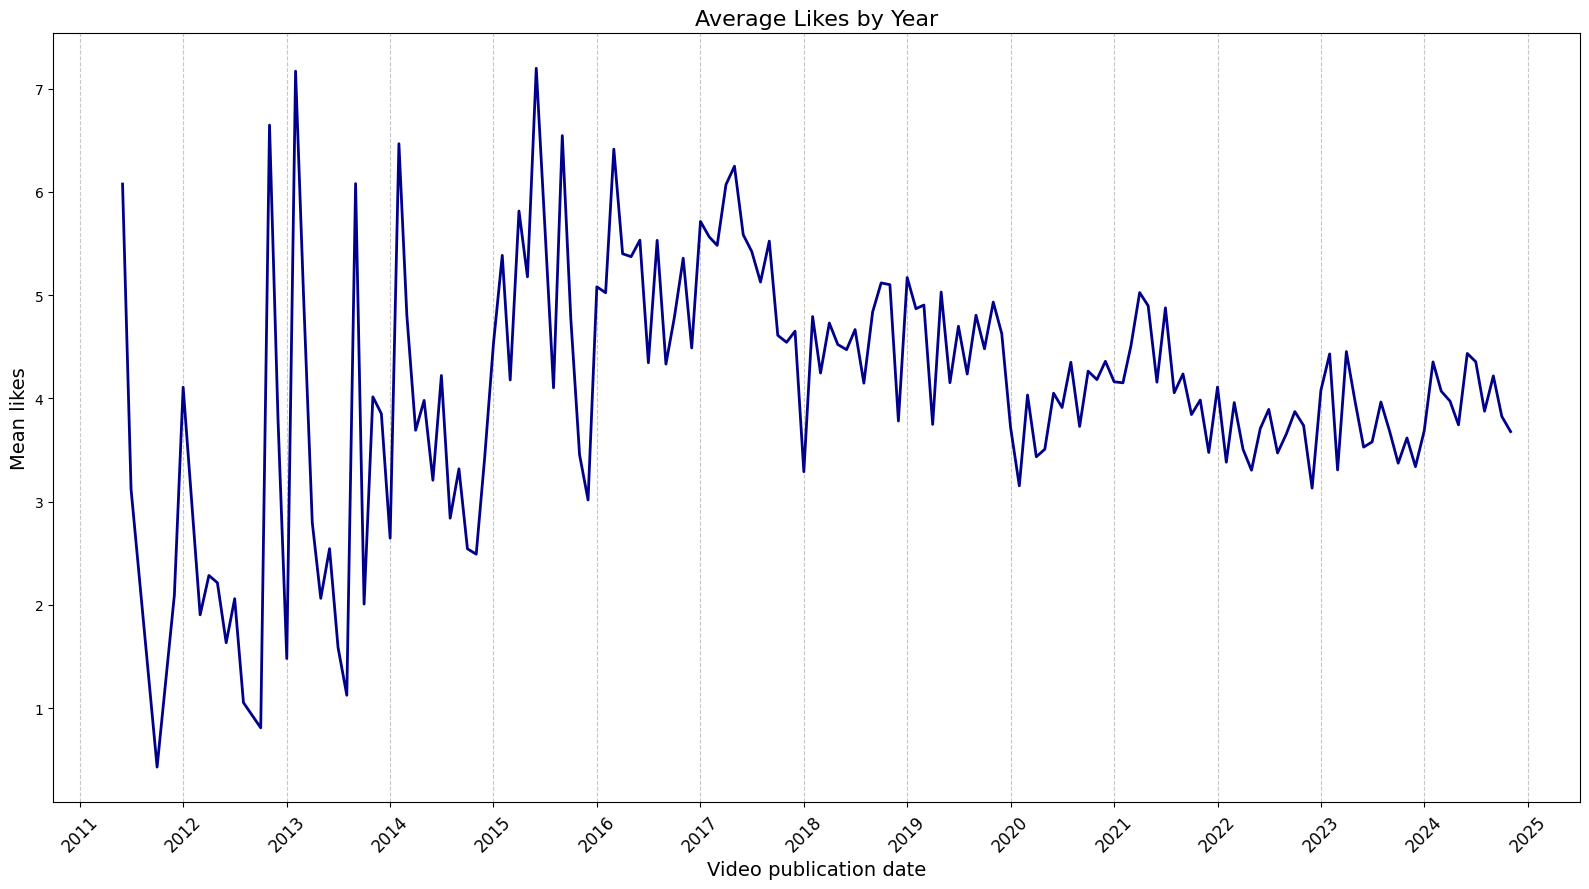

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))

plot_data = drop_outliers(plot_data, "Likes", 0.999)
monthly_likes = plot_data.groupby('Month')["Likes"].mean()

ax.plot(monthly_likes, color='darkblue', linewidth=2)

ax.set_xticks([datetime.date(year=y, month=1, day=1) for y in range(2011, 2026)])
ax.set_xticklabels(range(2011, 2026), fontsize=12, rotation=45)

ax.grid(axis='x', linestyle='--', alpha=0.7)

ax.set_xlabel('Video publication date', fontsize=14)
ax.set_ylabel('Mean likes', fontsize=14)
ax.set_title('Average Likes by Year', fontsize=16)

plt.tight_layout()
plt.show()


**Анализ графика**

На графике трудно выявить явную зависимость между годом и средним количеством лайков. В более ранние годы (2011-2017) график демонстрирует значительные колебания, вызванные ограниченным количеством данных. С течением времени колебания становятся менее выраженными, и наблюдается стабилизация показателей на примерно одном уровне. В целом, зависимость количества лайков от года выглядит слабой и, вероятно, обусловлена внешними факторами, а не внутренними трендами.

### **Анализ эмоциональности**

#### **Сравнение показателей**

В процессе подготовки и обработки данных были использованы два варианта показателя эмоциональности комментария:

- **Sentiment 1** — логарифмическое соотношение позитивных и негативных весов
- **Sentiment 2** — разность квадратов позитивных и негативных весов

Оба показателя принимают значения в диапазоне от -100 до 100, но имеют разные функции распределения. Для их сравнения построим графики, показывающие количество комментариев в зависимости от значения каждого из показателей.

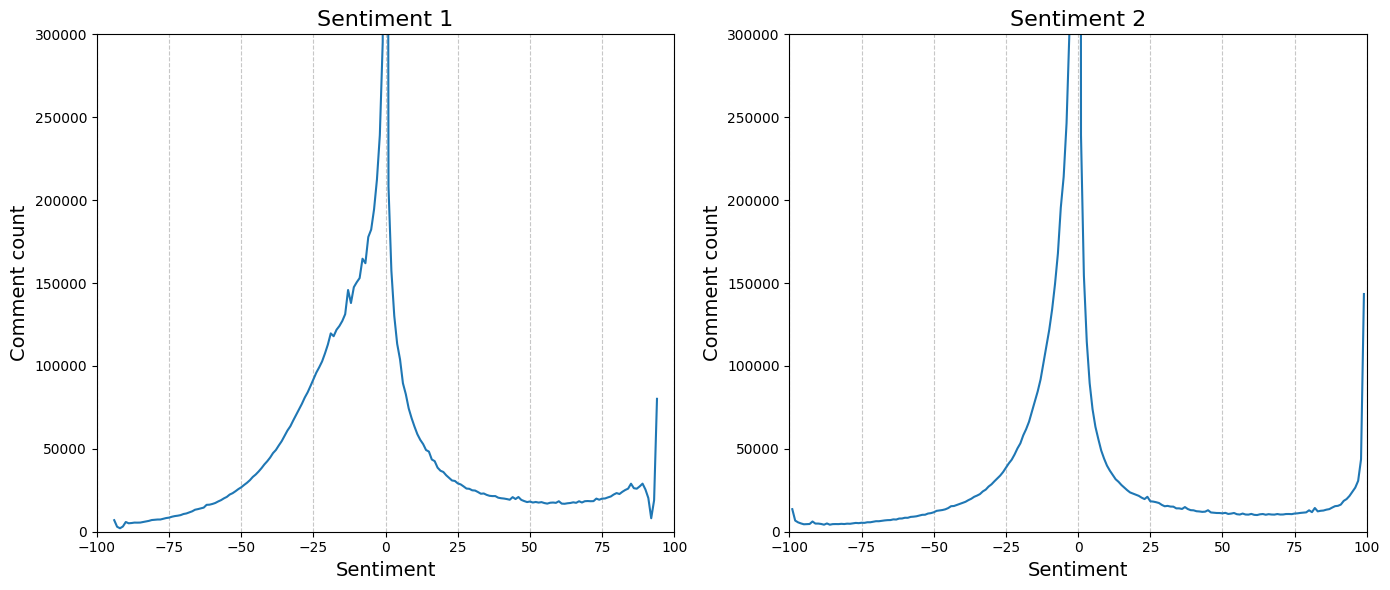

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Sentiment 1
ax[0].set(xticks=range(-100, 101, 25))
ax[0].grid(axis='x', linestyle='--', alpha=0.7)
ax[0].set_title("Sentiment 1", fontsize=16)
ax[0].set_xlabel("Sentiment", fontsize=14)
ax[0].set_ylabel("Comment count", fontsize=14)

ax[0].set(xlim=(-100, 100), ylim=(0, 300000))

plot_count(ax[0], "Sentiment 1", xstep=1)

# Sentiment 2
ax[1].set(xticks=range(-100, 101, 25))
ax[1].grid(axis='x', linestyle='--', alpha=0.7)
ax[1].set_title("Sentiment 2", fontsize=16)
ax[1].set_xlabel("Sentiment", fontsize=14)
ax[1].set_ylabel("Comment count", fontsize=14)

ax[1].set(xlim=(-100, 100), ylim=(0, 300000))

plot_count(ax[1], "Sentiment 2", xstep=1)

plt.tight_layout()
plt.show()


**Анализ графиков**

Графики имеют схожие особенности:

- Абсолютное большинство комментариев имеет значение, близкое к нулю.
- Имеется перекос в сторону немного негативных комментариев.
- Присутствует достаточно большое количество очень позитивных комментариев.

Однако на графике `Sentiment 1` можно заметить провалы в районе значений -90 и 90, которых нет на графике `Sentiment 2`. Эти провалы обусловлены кривизной функции на краях, когда значения положительных или отрицательных весов становятся слишком великими. В связи с этим для дальнейшего анализа в качестве показателя эмоциональности комментария будет использован `Sentiment 2`.

#### **Зависимость количества лайков от эмоциональности**

Проверим, существует ли связь между эмоциональностью комментариев и средним количеством лайков.

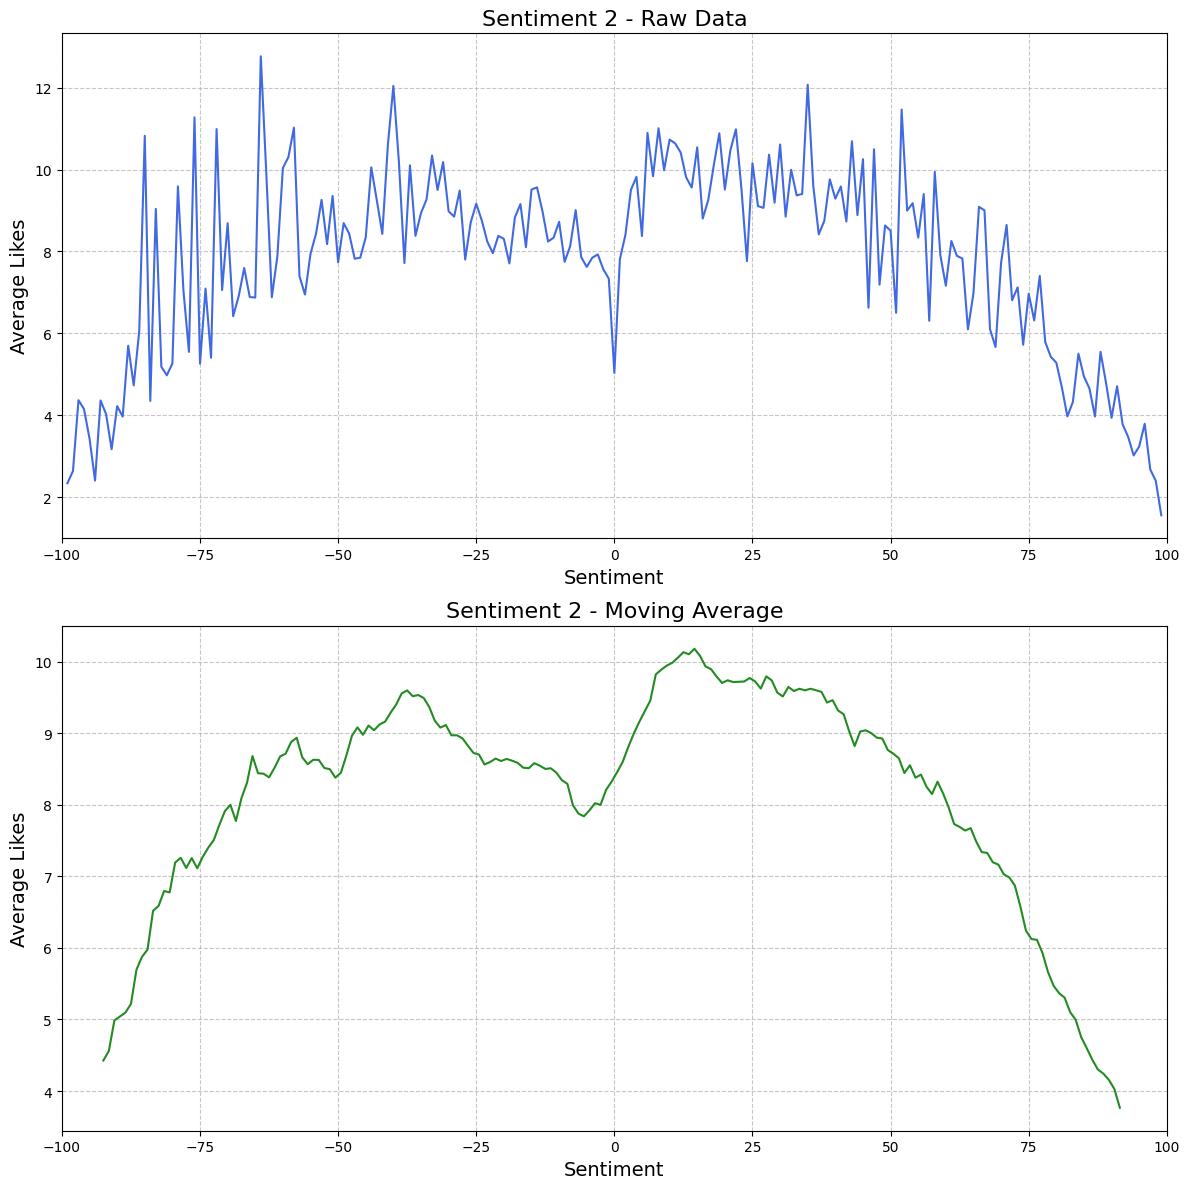

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Raw Data
ax[0].set(xticks=range(-100, 101, 25))
ax[0].grid(axis='x', linestyle='--', alpha=0.7)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].set_title("Sentiment 2 - Raw Data", fontsize=16)
ax[0].set_xlabel("Sentiment", fontsize=14)
ax[0].set_ylabel("Average Likes", fontsize=14)
ax[0].set(xlim=(-100, 100))

plot_likes(ax[0], "Sentiment 2", xstep=1, color='royalblue')

# Moving Average
ax[1].set(xticks=range(-100, 101, 25))
ax[1].grid(axis='x', linestyle='--', alpha=0.7)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].set_title("Sentiment 2 - Moving Average", fontsize=16)
ax[1].set_xlabel("Sentiment", fontsize=14)
ax[1].set_ylabel("Average Likes", fontsize=14)
ax[1].set(xlim=(-100, 100))

plot_likes(ax[1], "Sentiment 2", xstep=1, MA_window=15, color='forestgreen')

plt.tight_layout()
plt.show()


**Анализ графиков**

Хотя график и выглядит достаточно шумным, на нём можно заметить очевидную зависимость. Он почти симметричен относительно нуля. Комментарии с эмоциональной оценкой около нуля набирают гораздо меньше лайков. Далее, зависимость стремительно возрастает, достигает пика и затем медленно снижается к нулю по мере приближения к значению 100. Это вполне логично, ведь пользователям не интересны как чрезмерно положительные, так и сильно негативные комментарии, а также те, что не выражают ярких эмоций.

Интересно, что график не совсем симметричен: для позитивных комментариев максимальное количество лайков немного выше и ближе к нулю (~15), в то время как для негативных комментариев этот пик находится на более низком уровне (~-35).

#### **Эмоциональность каналов**

Для анализа возьмём топ-15 каналов с наибольшим количеством комментариев и сравним эмоциональность комментариев на этих каналах. Постараемся выявить, есть ли значимые различия в настроении пользователей в зависимости от канала.

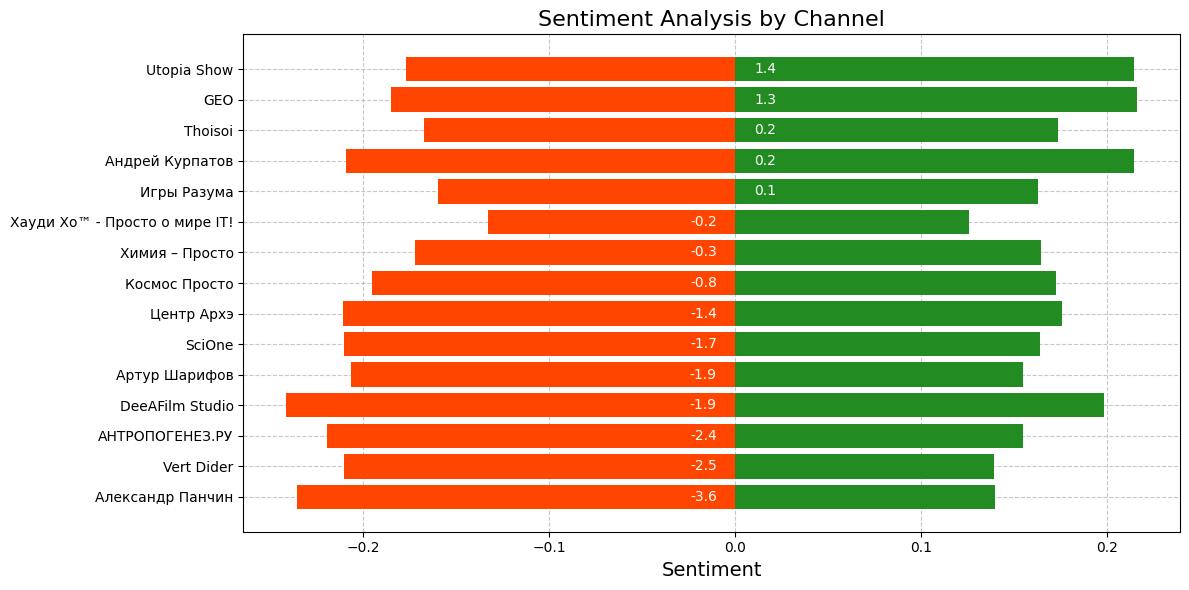

In [20]:
plot_data = ALL_DATA[["Channel name", "Positive weight", "Negative weight", "Neutral weight", "Sentiment 2"]]

n_comments = plot_data.groupby(by="Channel name", as_index=False).count()
n_comments = n_comments.rename(columns={"Positive weight": "Comments number"})
plot_data = plot_data.join(n_comments[["Channel name", "Comments number"]].set_index("Channel name"), on="Channel name")

plot_data = plot_data.groupby(by="Channel name", as_index=False)\
    .mean()\
    .sort_values(by="Comments number", ascending=False)\
    .head(15)

plot_data["Sentiment 2"] = (100*(plot_data["Positive weight"]**2 - plot_data["Negative weight"]**2))
plot_data = plot_data.sort_values(by="Sentiment 2")
plot_data['Sentiment 2'] = plot_data["Sentiment 2"].apply(lambda sent: round(sent, 1))

fig, ax = plt.subplots(figsize=(12, 6))

ax.grid(axis='y', linestyle='dashed', alpha=0.7)
pos_bar = ax.barh(plot_data["Channel name"], plot_data["Positive weight"], color='forestgreen', zorder=2)
neg_bar = ax.barh(plot_data["Channel name"], -plot_data["Negative weight"], color='orangered', zorder=2)

for bar, sentiment in zip(pos_bar, plot_data["Sentiment 2"]):
    if sentiment >= 0:
        ax.text(
            0.01, bar.get_y() + bar.get_height() / 2,
            f"{sentiment}", va='center', ha='left', color='white', fontsize=10, zorder=3
        )
    else:
        ax.text(
            -0.01, bar.get_y() + bar.get_height() / 2,
            f"{sentiment}", va='center', ha='right', color='white', fontsize=10, zorder=3
        )

ax.set_xlabel("Sentiment", fontsize=14)
ax.set_title("Sentiment Analysis by Channel", fontsize=16)
ax.grid(axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.show()


**Анализ графика**

Как и ожидалось, средние значения эмоциональности на всех каналах близки к нулю, что объясняется присутствием как позитивных, так и негативных комментариев, зачастую в равном количестве. Тем не менее, можно заметить различия между каналами: на некоторых из них отрицательная эмоциональность в два раза выше, чем положительная.

Это может быть связано с различными факторами, такими как возрастная аудитория канала, серьезность затрагиваемых тем, провокационность контента, манера подачи материала и многие другие аспекты, влияющие на восприятие зрителей.

## **Обучение модели**

На заключительном этапе проекта была разработана модель машинного обучения для предсказания количества лайков, которые может получить комментарий. В качестве входных данных использовались:

- **Эмбеддинги текста комментария**, полученные с помощью предобученной модели `FastText`, которые обеспечивают представление текста в виде векторных характеристик.
- **Дополнительные признаки**:
  - Длина текста комментария.
  - Эмоциональная окраска комментария.
  - Временной интервал между выходом видео и публикацией комментария.
  - Дата выхода видео, включая день недели и час выхода видео.

#### **Архитектура модели**

Для обработки данных была использована многоуровневая нейронная сеть, включающая следующие компоненты:

1. **Ветка для обработки эмбеддингов текста**: состояла из полносвязных слоёв с нормализацией и дропаутом для улучшения обобщающих способностей модели.
   
2. **Ветка для обработки дополнительных признаков**: аналогичная по структуре ветка, включающая полносвязные слои с нормализацией и дропаутом, для работы с признаками, такими как длина текста, эмоциональная окраска, временные характеристики.

Эти ветки объединялись в одной модели, после чего данные проходили через несколько полносвязных слоёв с добавлением **residual-соединений** для предотвращения переобучения.

Выходной слой представлял собой **линейный регрессор**, который прогнозировал целевую переменную — количество лайков, которое может получить комментарий.


In [21]:
import tensorflow as tf
from tensorflow.keras import models, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Add, LeakyReLU, PReLU, GRU, Reshape

# Входные данные
embedding_input = Input(shape=(300,), name="embedding_input")
features_input = Input(shape=(5,), name="features_input")

# Ветка обработки эмбеддингов
embedding_branch = Dense(128, kernel_regularizer=regularizers.L2(1e-5))(embedding_input)
embedding_branch = LeakyReLU(alpha=0.1)(embedding_branch)
embedding_branch = BatchNormalization()(embedding_branch)
embedding_branch = Dropout(0.3)(embedding_branch)

# Ветка обработки дополнительных признаков
features_branch = Dense(64, kernel_regularizer=regularizers.L2(1e-5))(features_input)
features_branch = LeakyReLU(alpha=0.1)(features_branch)
features_branch = BatchNormalization()(features_branch)
features_branch = Dropout(0.3)(features_branch)


# Объединение всех веток
combined = Concatenate()([embedding_branch, features_branch])

# Первый скрытый слой после объединения
hidden = Dense(128)(combined)
hidden = PReLU()(hidden)  # Использование PReLU вместо LeakyReLU
hidden = BatchNormalization()(hidden)
hidden = Dropout(0.3)(hidden)

# Residual соединение
residual = Dense(128, kernel_regularizer=regularizers.L2(1e-5))(combined)
hidden = Add()([hidden, residual])
hidden = PReLU()(hidden)  # Использование PReLU

# Второй скрытый слой
hidden = Dense(64)(hidden)
hidden = PReLU()(hidden)
hidden = BatchNormalization()(hidden)
hidden = Dropout(0.3)(hidden)

# Выходной слой
output = Dense(1, activation="linear")(hidden)

# Модель
model = models.Model(inputs=[embedding_input, features_input], outputs=output)

# Компиляция модели с адаптивной скоростью обучения
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='huber_loss',
              metrics=['mae', 'mse'])

# Вывод архитектуры модели
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 300)]                0         []                            
 r)                                                                                               
                                                                                                  
 features_input (InputLayer  [(None, 5)]                  0         []                            
 )                                                                                                
                                                                                                  
 dense (Dense)               (None, 128)                  38528     ['embedding_input[0][0]']     
                                                                                              

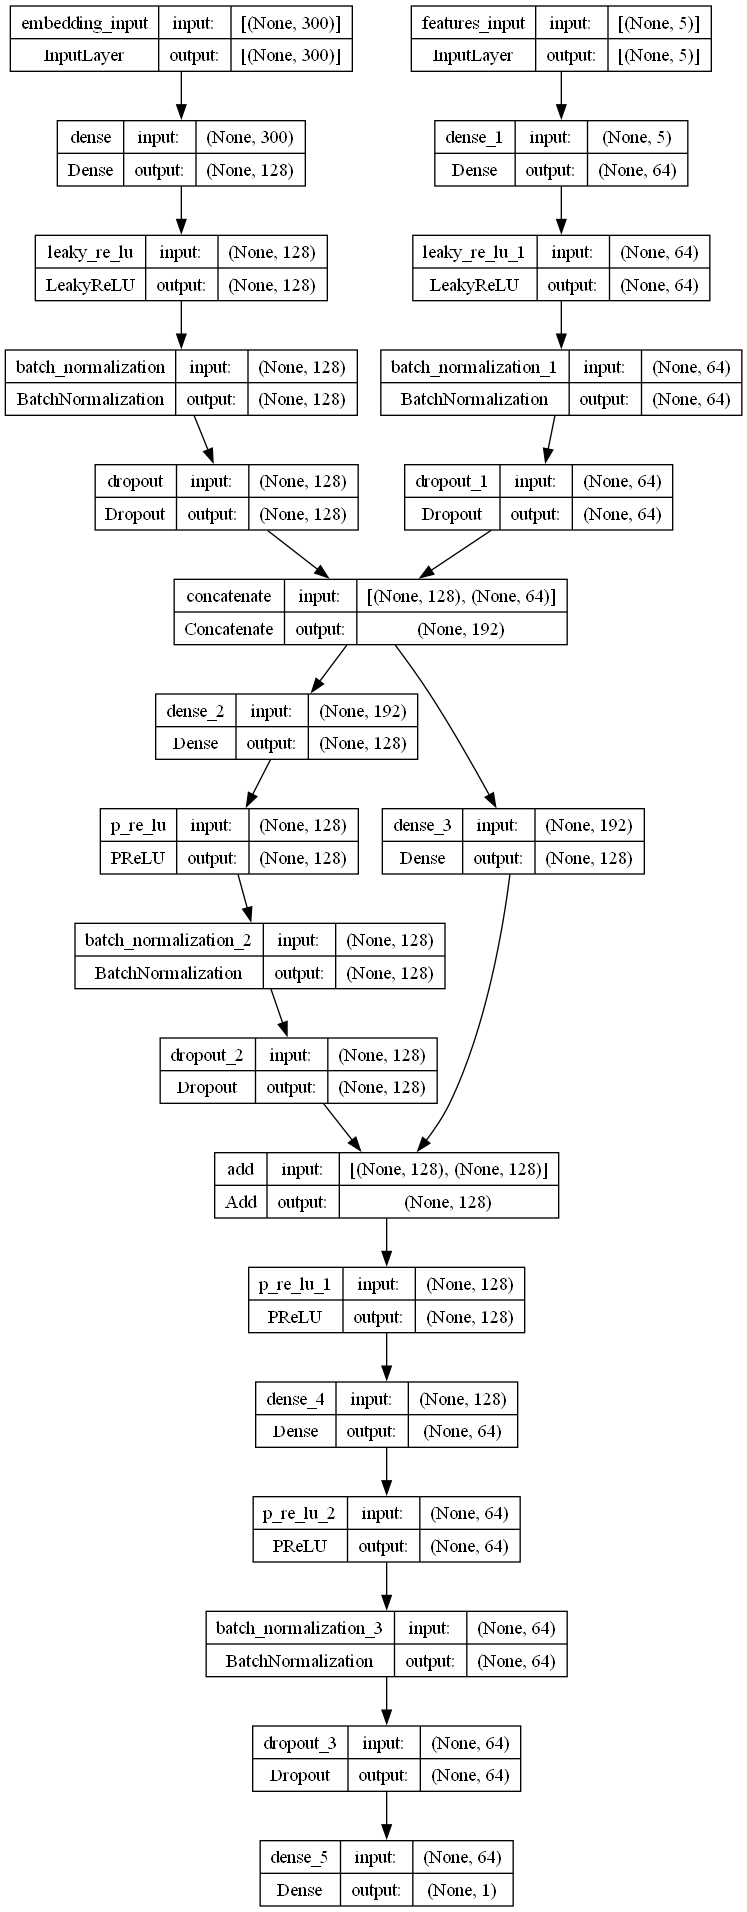

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="img/model.png", show_shapes=True, show_layer_names=True)

#### **Подготовка обучающих данных**

In [23]:
import fasttext
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore')
ft_model = fasttext.load_model('cc.ru.300.bin')

In [24]:
def extract_time_features(df):
    df['Video dayofweek'] = df['Video publication date'].apply(parse_iso_date).dt.dayofweek  # День недели (0=Понед.)
    df['Video hour'] = df['Video publication date'].apply(parse_iso_date).dt.hour
    return df[['Video dayofweek', 'Video hour']]

num_samples = 2_000_000

df = ALL_DATA.dropna().sample(num_samples)

sample_sentences = pd.DataFrame()
sample_sentences["text"] = df["Text"].astype(str).apply(lambda t: t.replace('\n', ' '))

embeddings = sample_sentences["text"].apply(ft_model.get_sentence_vector)

embeddings = embeddings.to_numpy()
embeddings = np.concatenate(embeddings, axis=0).reshape(df.shape[0], 300)
features = df[["Text len", "Sentiment 2", "Time delta"]].to_numpy()
time_features = extract_time_features(df).to_numpy()
features = np.concatenate((features, time_features), axis=1)

targets = df["Likes"].to_numpy()


In [25]:
print(embeddings.shape)
print(features.shape)
print(targets.shape)

(2000000, 300)
(2000000, 5)
(2000000,)


In [26]:
from sklearn.preprocessing import StandardScaler

# Функция для нормализации данных
def normalize_data(features, targets):
    # Создаем скейлеры для нормализации признаков и целей
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    # Нормализуем признаки
    features_scaled = feature_scaler.fit_transform(features)
    targets_scaled = target_scaler.fit_transform(targets.reshape(-1, 1))

    # Сохраняем коэффициенты нормализации
    return features_scaled, targets_scaled, feature_scaler, target_scaler

# Если нужно нормализовать новые данные (например, для предсказаний):
def normalize_new_data(new_features, feature_scaler):
    new_features_scaled = feature_scaler.transform(new_features)
    return new_features_scaled


#### **Процесс обучения**

- Модель обучалась на случайной выборке из 2 000 000 комментариев.
- Для нормализации данных использовался `StandardScaler`, что обеспечивало стабильность и эффективность работы градиентного спуска.
- В качестве функции потерь была выбрана **Huber Loss**, поскольку она хорошо справляется с шумными данными и снижает влияние выбросов на процесс обучения.

Кроме того, была применена **ранняя остановка** на основе значения ошибки на валидационной выборке (`val_loss`). Это помогло предотвратить переобучение.

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

if input("Load weights?? Y/n: ").lower() in ['y', '']:
    model.load_weights('model/model_weights')
else:

    # Нормализация данных
    features_scaled, targets_scaled, feature_scaler, target_scaler = normalize_data(features, targets)

    # Разделение данных на обучающую и тестовую выборки
    embeddings_train, embeddings_test, \
    features_train, features_test, \
    targets_train, targets_test = train_test_split(embeddings, features_scaled, targets_scaled, test_size=0.2, random_state=42)

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    )

    # Обучение модели
    history = model.fit(
        [embeddings_train, features_train],
        targets_train,
        validation_data=([embeddings_test, features_test], targets_test),
        epochs=25,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )

    model.save_weights('model/model_weights')

Epoch 1/25
25000/25000 [==============================] - 82s 3ms/step - loss: 0.0664 - mae: 0.1373 - mse: 1.0921 - val_loss: 0.0344 - val_mae: 0.0659 - val_mse: 0.9386
Epoch 2/25
25000/25000 [==============================] - 78s 3ms/step - loss: 0.0340 - mae: 0.0645 - mse: 1.0155 - val_loss: 0.0343 - val_mae: 0.0651 - val_mse: 0.9381
Epoch 3/25
25000/25000 [==============================] - 78s 3ms/step - loss: 0.0339 - mae: 0.0644 - mse: 1.0152 - val_loss: 0.0343 - val_mae: 0.0617 - val_mse: 0.9386
Epoch 4/25
25000/25000 [==============================] - 79s 3ms/step - loss: 0.0339 - mae: 0.0642 - mse: 1.0151 - val_loss: 0.0343 - val_mae: 0.0654 - val_mse: 0.9379
Epoch 5/25
25000/25000 [==============================] - 79s 3ms/step - loss: 0.0339 - mae: 0.0642 - mse: 1.0151 - val_loss: 0.0343 - val_mae: 0.0636 - val_mse: 0.9379
Epoch 6/25
25000/25000 [==============================] - 78s 3ms/step - loss: 0.0339 - mae: 0.0641 - mse: 1.0151 - val_loss: 0.0343 - val_mae: 0.0643 - va

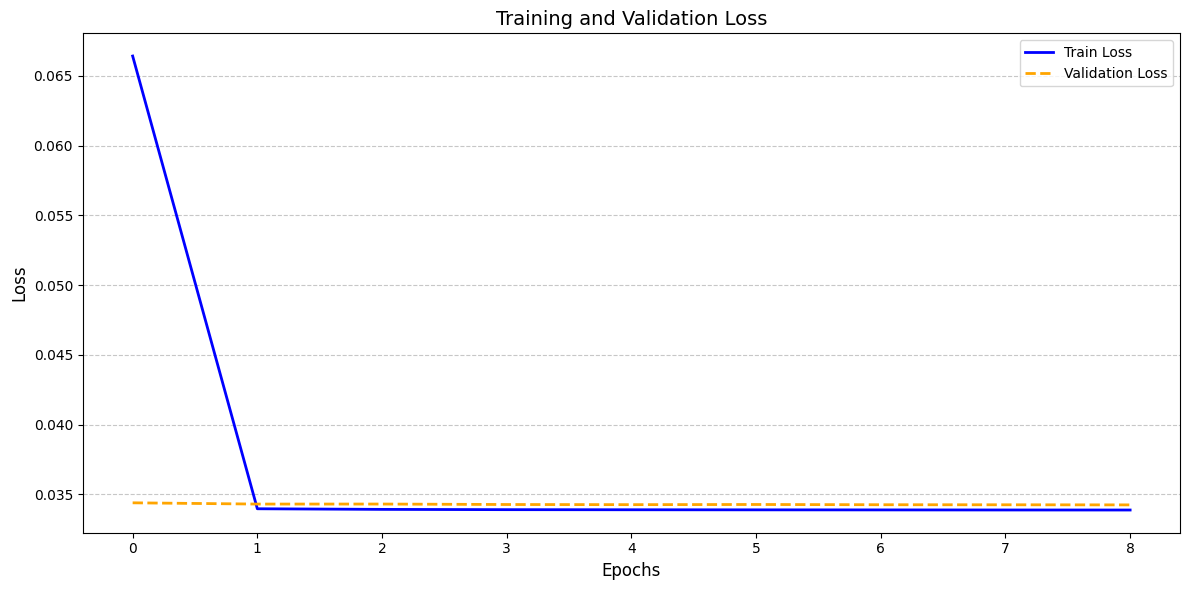

In [28]:

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='-', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)

plt.legend()

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training and Validation Loss', fontsize=14)

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### **Оценка результатов обучения**

После завершения обучения модель была применена ко всему датасету для вычисления коэффициента корреляции между предсказаниями и фактическими значениями (количеством лайков).

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Создаем столбец для предсказаний, если его нет
ALL_DATA["Prediction"] = np.nan

# Параметры батча
batch_size = 1000
n_batches = int(np.ceil(ALL_DATA.shape[0] / batch_size))

print("Processing batches...")
for i in tqdm(range(n_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, ALL_DATA.shape[0])
    
    # Данные текущего батча
    batch = ALL_DATA.iloc[start_idx:end_idx]  # Используем iloc для выбора батча
    
    # Извлечение текстов и преобразование в эмбеддинги
    sample_sentences = batch["Text"].astype(str).apply(lambda t: t.replace('\n', ' '))
    batch_embeddings = np.stack(sample_sentences.apply(ft_model.get_sentence_vector).to_numpy())
    
    # Извлечение дополнительных признаков
    batch_features = batch[["Text len", "Sentiment 2", "Time delta"]].to_numpy()
    batch_time_features = extract_time_features(batch).to_numpy()
    batch_features = np.concatenate((batch_features, batch_time_features), axis=1)
    batch_features_scaled = normalize_new_data(batch_features, feature_scaler)
    
    # Предсказания
    predictions_scaled = model.predict([batch_embeddings, batch_features_scaled], verbose=0)
    predictions = target_scaler.inverse_transform(predictions_scaled).flatten()
    
    # Запись предсказаний обратно в ALL_DATA
    ALL_DATA["Prediction"][start_idx:end_idx] = predictions

print("Predictions completed.")


In [31]:
ALL_DATA.to_csv('data/alldata_predictions.csv')

#### **Оценка результатов обучения модели**

Для оценки результатов обучения модели был вычислен коэффициент корреляции между предсказаниями и целевым значением (количеством лайков). Также был построен точечный график, который наглядно демонстрирует соответствие предсказанных и фактических значений.

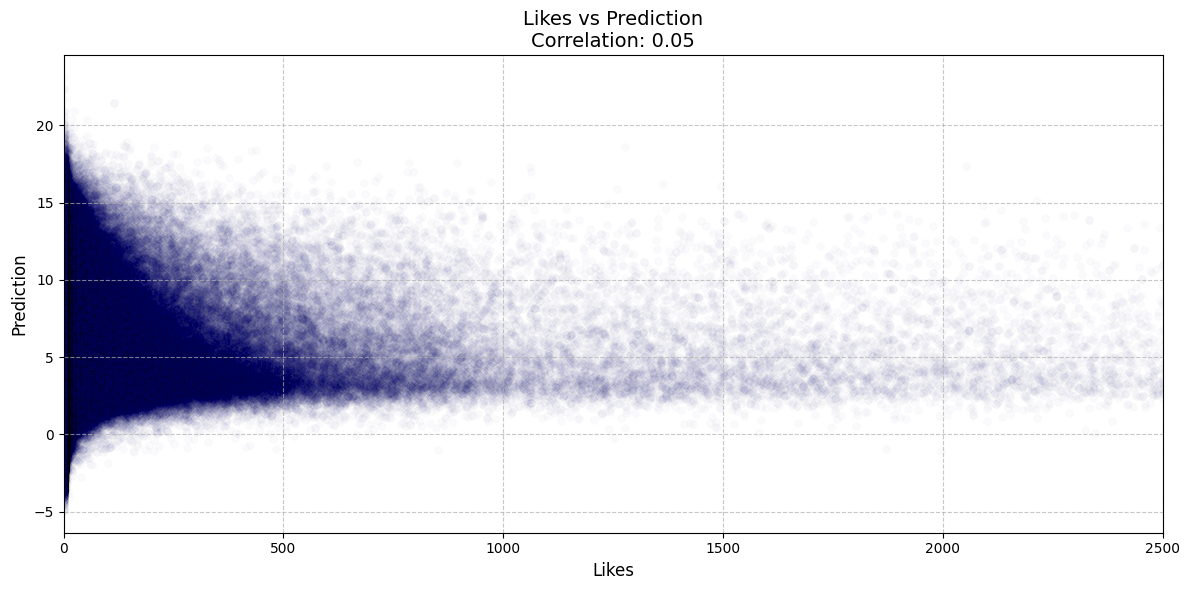

In [32]:
correlation = ALL_DATA["Likes"].corr(ALL_DATA["Prediction"])

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(
    ALL_DATA["Likes"], 
    ALL_DATA["Prediction"], 
    alpha=0.02, 
    color='darkblue', 
    edgecolors='black', 
    s=30, 
    linewidth=0.5
)

ax.set(xlim=(0, 2500))

ax.set_xlabel("Likes", fontsize=12)
ax.set_ylabel("Prediction", fontsize=12)
ax.set_title(f"Likes vs Prediction\nCorrelation: {correlation:.2f}", fontsize=14)

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


**Анализ графика**

Вычисленный коэффициент корреляции между предсказаниями и целевым значением равен 0.05, что указывает на крайне слабую зависимость между ними. Это означает, что модель не смогла выстроить четкую связь между текстовыми признаками и количеством лайков.

Тем не менее, на графике можно заметить, что предсказания имеют некоторую структуру, распределяясь между двумя гладкими кривыми. Однако в целом результат обучения остается неудовлетворительным. Например, если модель предсказывает количество лайков, равное 2, это число встречается как у комментариев с 0, так и с 2500 лайками, что делает такие предсказания практически бесполезными.

**Вероятные причины неудачи:**

- **Сложность задачи:** Количество лайков под комментариями — это крайне непредсказуемая величина, на которую влияет множество явных и неявных факторов, взаимодействующих между собой. Это делает задачу предсказания количества лайков сложной и требующей более продвинутых методов обучения для решения.
- **Неполный набор параметров:** Возможно, некоторые важные параметры не были учтены при проектировании модели. Например, содержание видео или "эффект первого лайка" (когда комментарий, уже набравший несколько лайков, имеет большую вероятность продолжать набирать лайки, в отличие от комментария без лайков).
- **Неравномерность обучающих данных:** Более 90% обучающих данных составляют комментарии с 5 и менее лайками, что делает модель склонной к предсказаниям, близким к этим низким значениям и ограничивает её способность правильно предсказывать комментарии с большим количеством лайков.

![](img/meme.jpg)

## **Итог проекта**

В рамках проекта был проведён анализ пользовательских комментариев на платформе YouTube с целью создания модели для предсказания количества лайков под комментариями. Проект включал несколько этапов, каждый из которых позволил значительно развить технические навыки в области обработки данных и машинного обучения с использованием Python и его библиотек.

1. **Сбор и обработка данных:**  
   - Для анализа было собрано более 10 миллионов комментариев, что потребовало работы с большими объёмами данных. В процессе работы активно использовались библиотеки `pandas` и `numpy` для очистки и обработки данных, таких как фильтрация, нормализация и трансформация данных в удобный формат для дальнейшего анализа.  
   - Для работы с текстами комментариев применялась библиотека `FastText` для получения эмбеддингов текста, что позволило эффективно представлять текстовые данные в числовом виде для дальнейшей обработки в модели. Дополнительно использовалась библиотека `Dostoevsky` для анализа эмоциональной окраски текста с помощью алгоритмов классификации.

2. **Анализ данных:**  
   - В процессе анализа данных использовались различные методы статистического анализа, а также визуализация данных с помощью библиотек `matplotlib` и `seaborn`. Для выявления закономерностей, таких как зависимость длины комментариев от их популярности и временные паттерны активности, были построены различные типы графиков и диаграмм.  
   - Обнаружение аномалий, таких как спам и колебания активности, потребовало применения методов фильтрации.

3. **Разработка и обучение модели:**  
   - Для создания модели был использован фреймворк `TensorFlow` с библиотекой `Keras` для построения многоуровневой нейронной сети.  
   - В процессе обучения модели были применены методы, такие как нормализация данных с использованием `StandardScaler` (библиотека `scikit-learn`), использование функции потерь **Huber Loss**, которая хорошо подходит для работы с шумными данными, а также техника ранней остановки для предотвращения переобучения.

**Направления для улучшения:**
1. Расширение набора признаков, включая дополнительные данные о содержании видео и социальные эффекты, что потребует дополнительных инструментов для работы с метаданными и анализа социальных сетей.  
2. Использование более сложных архитектур моделей для улучшения предсказаний на основе более сложных зависимостей.  

Проект предоставил ценную возможность попрактиковаться в применении инструментов Python для решения задач машинного обучения и анализа данных. Полученные навыки и знания в области обработки данных, машинного обучения и работы с большими данными будут полезны для разработки более сложных систем и моделей в будущем.